<a href="https://colab.research.google.com/github/matthewpecsok/4482_fall_2022/blob/main/tutorials/4482_hyperparameters_and_grid_search_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Decision Trees have multiple method parameters that are set by default such

*   **ccp_alpha** : non-negative float, default=0.0
*   **criterion** : {"gini", "entropy"}, default="gini"
*   **splitter** : {"best", "random"}, default="best"
*   **min_samples_leaf** : int or float, default=1

Given that we know that if left to their defaults our DecisionTree model will severly overfit it is important to consider changing these parameters. In other cases not changing the default might lead to underfitting. 

**Hyperparameters:**

In Data Mining a **model parameter** that can be **changed** and impacts the model's learning process is known as a **`hyperparameter`**. It is critical to find the **'right'** hyperparameter value that makes our model perform the best. Given that there are an **infinite** number of values between 0,1 just for ccp_alpha how would we go about finding the **'best'** hyperparameter or an even more complex problem, the best combination of hyperparameters?

This notebook will guide you through the fundamentals of a naive approach all the way through a more robust automated approach.









In [ ]:
from sklearn import tree
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.3f}'.format # when creating means and std dev from our
# metrics we would get scientific notation without specifying this

try 3 possible values for the ccp_alpha hyperparameter

In [ ]:
tree_model_ccp_0 = tree.DecisionTreeClassifier(ccp_alpha=0)
tree_model_ccp_5 = tree.DecisionTreeClassifier(ccp_alpha=0.5)
tree_model_ccp_10 = tree.DecisionTreeClassifier(ccp_alpha=1)

In [ ]:
model_list = [
    tree_model_ccp_0,
    tree_model_ccp_5,
    tree_model_ccp_10
]

prep our data (greatly simplified)

In [ ]:
titanic = pd.read_csv("https://raw.githubusercontent.com/matthewpecsok/4482_fall_2022/main/data/titanic_cleaned.csv")
titanic = titanic.astype({'Survived': 'category',
                                          'Sex': 'category',
                                          'Pclass': 'category',
                                          'Cabin': 'category',
                                          'Embarked': 'category'})
y_target = titanic.pop('Survived')
titanic_enc = pd.get_dummies(titanic)
from sklearn.model_selection import cross_validate


loop through all 3 models and evaluate each

In [ ]:
for model in model_list:
  scores = cross_validate(
    model, titanic_enc, y_target, cv=3, scoring=['f1','accuracy','recall','precision'],return_train_score=True)
  df = pd.DataFrame(scores)
  df = df[['test_accuracy','train_accuracy']]
  df['train-test'] = df.train_accuracy-df.test_accuracy
  print(f'for ccp_alpha={model.ccp_alpha}\n {df.mean()}\n')

Our model with ccp_alpha = 0 is the best with the highest test accuracy, but it's also overfitting severly. So, a reasonable approach would be to try values closer to 0. Again, this could be done by hand but takes time, and imagine if we were trying to find the best combination of hyperparameters not just ccp_alpha, but 2,3 or even 10 total hyperparameter combinations. That would be a lot of combinations to try!

**Grid Search**

Discovering the best combination turns out to be a common issue for data scientists, so packages have been built to help expedite the process. 

Using grid search we can put in multiple combinations of hyperparameters and the package will try each of those combination using cross validation. It can help us discover which combinations perform the best. 



In [ ]:
from sklearn.model_selection import GridSearchCV

try 6 possible combinations (more than our original 3)
all of the values are between 0 and .5 a much reduced range than our original test.

Notice that we are not creating multiple models by hand, but rather the grid search operation is taking care of this for us. 

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'ccp_alpha':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
              }

# create the model and pass it to grid search
# also pass the range of parameters we want grid search to test
tree_model = tree.DecisionTreeClassifier(random_state=42) #notice how we are intentionally not setting ccp_alpha, grid search will do that for us
clf_0 = GridSearchCV(tree_model, parameters,scoring='accuracy',cv=3,return_train_score=True) # 3 fold cross-validation
clf_0.fit(titanic_enc, y_target)

# get the results and format
grid_search_results = pd.DataFrame(clf_0.cv_results_)
grid_search_results = grid_search_results[['rank_test_score','param_ccp_alpha','mean_test_score','mean_train_score']]
grid_search_results['mean_score_diff_test_train'] = grid_search_results.mean_test_score - grid_search_results.mean_train_score
grid_search_results.sort_values(by='rank_test_score')

,rank_test_score,param_ccp_alpha,mean_test_score,mean_train_score,mean_score_diff_test_train
1,1,0.100,0.780,0.780,-0.000
0,2,0,0.772,0.992,-0.221
2,3,0.200,0.594,0.594,0.000
3,3,0.300,0.594,0.594,0.000
4,3,0.400,0.594,0.594,0.000
5,3,0.500,0.594,0.594,0.000
6,3,0.600,0.594,0.594,0.000
7,3,0.700,0.594,0.594,0.000
8,3,0.800,0.594,0.594,0.000
9,3,0.900,0.594,0.594,0.000


Let's summarize the results above. It appears that a ccp_alpha of 0.1 has achived the best test score and we don't see any signs of overfitting as shown in the difference between train and test column added to our dataframe.

So, we again focus on numbers close to 0, but would like to look at smaller ranges of ccp_alpha such as 0.004 or 0.008 since those are close to 0.1. 

We still have an infinite amount of possible values to test. We'll narrow in on a smaller range one more time before showing you a easier way to approach this problem. 

But first, we are going to make our lives easier with a quick function. 

In [ ]:
def format_results(clf):
  # get the results and format
  grid_search_results = pd.DataFrame(clf.cv_results_)
  grid_search_results = grid_search_results[['rank_test_score','param_ccp_alpha','mean_test_score','mean_train_score']]
  grid_search_results['mean_score_diff_test_train'] = grid_search_results.mean_test_score - grid_search_results.mean_train_score
  return(grid_search_results.sort_values(by='rank_test_score'))

In [ ]:
format_results(clf_0)

,rank_test_score,param_ccp_alpha,mean_test_score,mean_train_score,mean_score_diff_test_train
1,1,0.100,0.780,0.780,-0.000
0,2,0,0.772,0.992,-0.221
2,3,0.200,0.594,0.594,0.000
3,3,0.300,0.594,0.594,0.000
4,3,0.400,0.594,0.594,0.000
5,3,0.500,0.594,0.594,0.000
6,3,0.600,0.594,0.594,0.000
7,3,0.700,0.594,0.594,0.000
8,3,0.800,0.594,0.594,0.000
9,3,0.900,0.594,0.594,0.000


In [ ]:
import numpy as np
from decimal import getcontext, Decimal

also help us generate all numbers between 0 and 1 in .1 increments

In [ ]:
np.arange(0,1.1,.1) # show how it works

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
np.arange(0,1,.01) # show how it works

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

also help us generate all numbers between 0 and 1 in .01 increments

In [ ]:
parameters = {'ccp_alpha':np.arange(0,1,.01)
              }

# create the model and pass it to grid search
# also pass the range of parameters we want grid search to test
tree_model = tree.DecisionTreeClassifier(random_state=42) #notice how we are intentionally not setting ccp_alpha, grid search will do that for us
clf_1 = GridSearchCV(tree_model, parameters,scoring='accuracy',cv=3,return_train_score=True) # 3 fold cross-validation
clf_1.fit(titanic_enc, y_target)



GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
             return_train_score=True, scoring='accuracy')

In [ ]:
format_results(clf_1)

,rank_test_score,param_ccp_alpha,mean_test_score,mean_train_score,mean_score_diff_test_train
1,1,0.010,0.812,0.813,-0.001
2,2,0.020,0.791,0.791,0.000
3,2,0.030,0.791,0.791,0.000
11,4,0.110,0.780,0.780,-0.000
6,4,0.060,0.780,0.780,-0.000
...,...,...,...,...,...
39,16,0.390,0.594,0.594,0.000
38,16,0.380,0.594,0.594,0.000
37,16,0.370,0.594,0.594,0.000
45,16,0.450,0.594,0.594,0.000


This has been a productive search of ccp_alpha, we appear to have found a range of ccp_alpha that gives us our highest train and test scores with no overfitting (0.010)

What if I wanted to try many different combinations of multiple hyperparameters? 

we already ran 300 models, if I wanted to try a different criterion for each of those ccp_alpha values that would be 2*300 = 600 models, and if I also wanted to try a different splitting strategy that would be 2*2*300 = 1200 models!

There must be a more efficient way to approach this introducing:

**Randomized Grid Search**

Randomized grid search allows us to pass minimum value, and a maximum value and have the algorithm randomly test numbers within that range. It has been proven to be far more effective at finding a combination of best parameters than simply trying it by hand.


In [ ]:
def format_results_random_gs(clf):
  # get the results and format
  grid_search_results = pd.DataFrame(clf.cv_results_)
  grid_search_results = grid_search_results[['rank_test_score','param_ccp_alpha','param_criterion','param_splitter','param_min_samples_leaf','mean_test_score','mean_train_score']]
  grid_search_results['mean_score_diff_test_train'] = grid_search_results.mean_test_score - grid_search_results.mean_train_score
  return(grid_search_results.sort_values(by='rank_test_score'))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
parameters = {'ccp_alpha':np.arange(0,1,.001), # 1000 possible ccp_alpha choices in increments of 0.001
              'criterion' : ['gini','entropy'],
              'splitter' : ['best','random'],
              'min_samples_leaf' : [1,2,3,4,5,6,7,8,9,10]
              }

# create the model and pass it to grid search
# also pass the range of parameters we want grid search to test
tree_model = tree.DecisionTreeClassifier(random_state=42) #notice how we are intentionally not setting ccp_alpha, grid search will do that for us
clf_2 = RandomizedSearchCV(tree_model, 
                         parameters,
                         n_iter=1000, # try 1000 models sampling from the 1000*2*2*10 = 40,000 possible hyperparameter choices
                         scoring='accuracy',
                         cv=3,
                         return_train_score=True) # 3 fold cross-validation
clf_2.fit(titanic_enc, y_target)



RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=1000,
                   param_distributions={'ccp_alpha': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0....
       0.963, 0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.97 , 0.971,
       0.972, 0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.979, 0.98 ,
       0.981, 0.982, 0.983, 0.984, 0.985, 0.986, 0.987, 0.988, 0.989,
       0.99 , 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998,
       0.999]),
                                        'criterion': ['gini', 'entropy'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
        

In [ ]:
random_search_results = format_results_random_gs(clf_2)
random_search_results

,rank_test_score,param_ccp_alpha,param_criterion,param_splitter,param_min_samples_leaf,mean_test_score,mean_train_score,mean_score_diff_test_train
618,1,0.023,entropy,best,5,0.812,0.812,0.001
721,1,0.011,gini,best,3,0.812,0.813,-0.001
431,3,0.016,entropy,best,10,0.807,0.806,0.001
959,4,0.032,entropy,best,2,0.804,0.807,-0.003
977,5,0.002,gini,best,4,0.803,0.880,-0.078
...,...,...,...,...,...,...,...,...
374,182,0.817,gini,best,9,0.594,0.594,0.000
376,182,0.944,gini,random,7,0.594,0.594,0.000
377,182,0.978,entropy,best,5,0.594,0.594,0.000
348,182,0.272,gini,random,3,0.594,0.594,0.000


Text(0.5, 1.0, 'mean test accuracy over 3 fold cv varying ccp_alpha')

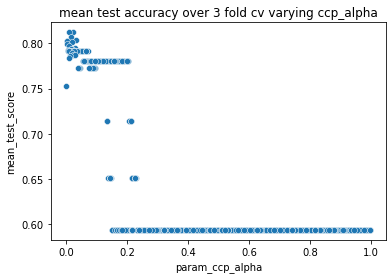

In [ ]:
sns.scatterplot(data=random_search_results, x="param_ccp_alpha", y="mean_test_score")
plt.title('mean test accuracy over 3 fold cv varying ccp_alpha')